In [1]:
from CHECLabPy.core.io import HDF5Reader
import pickle
import numpy as np
from numpy.polynomial.polynomial import polyfit, polyval
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
with HDF5Reader("charge_lab.h5") as reader:
    df_lab_40mhz = reader.read("nsb40mhz")

Opening HDF5 file: charge_lab.h5
Reading entire DataFrame (nsb40mhz) from HDF5 file into memory


# Calibration

In [3]:
def calibrate_illumination(df, spe_path):
    with open(spe_path, 'rb') as file:
        spe = pickle.load(file)
    
    n_illuminations = spe['n_illuminations']
    est_illumination = np.zeros(n_illuminations)
    lambda_ = np.zeros(n_illuminations)
    lambda_err = np.zeros(n_illuminations)
    for i in range(n_illuminations):
        est_illumination[i] = spe[f'estimated_illumination_pe{i}']
        lambda_[i] = spe[f'lambda_{i}']
        lambda_err[i] = spe[f'lambda_{i}_err']

    plt.errorbar(est_illumination, lambda_, yerr=lambda_err, label="Measured")
    c = polyfit(est_illumination, lambda_, 1, w=1/lambda_err)
    plt.plot(est_illumination, polyval(est_illumination, c), label="Fit")
    plt.xlabel("Estimated Illumination (p.e.)")
    plt.ylabel("Lambda (p.e.)")

    df['illumination_pe'] = polyval(df['estimated_illumination_pe'], c)

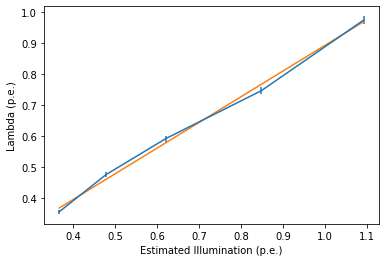

In [4]:
calibrate_illumination(df_lab_40mhz, 'spe_lab.pkl')

In [5]:
def calibrate_charge(df):
    illumination = df['illumination_pe']
#     index = (1e1 < illumination) & (illumination < 1e2)
#     df_calib = df.loc[index]
    index = (illumination < 1e2)
    df_calib = df.loc[index]

    illumination = df_calib['illumination_pe']
    charge = df_calib['charge']
    c = polyfit(illumination, charge, 1)

    plt.plot(illumination, charge, '.')
    plt.plot(illumination, polyval(illumination, c))
    
    df['charge_pe'] = (df['charge'] - c[0]) / c[1]

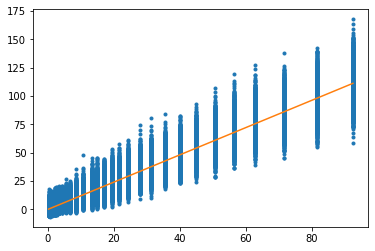

In [6]:
calibrate_charge(df_lab_40mhz)

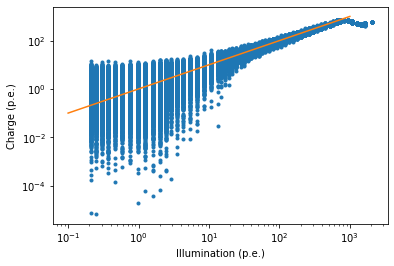

In [7]:
# Plot Dynamic Range
plt.plot(df_lab_40mhz['illumination_pe'], df_lab_40mhz['charge_pe'], '.')
plt.plot(np.geomspace(0.1, 1000), np.geomspace(0.1, 1000))
plt.xlabel("Illumination (p.e.)")
plt.ylabel("Charge (p.e.)")
plt.xscale('log')
plt.yscale('log')
# plt.xlim([0, 1000])

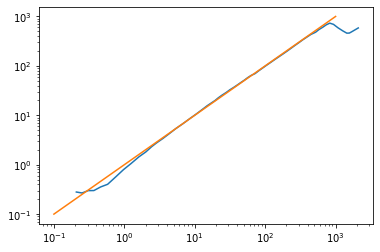

In [8]:
df_mean = df_lab_40mhz.groupby('illumination_pe').mean()
plt.plot(df_mean.index, df_mean['charge_pe'])
plt.plot(np.geomspace(0.1, 1000), np.geomspace(0.1, 1000))
plt.xscale('log')
plt.yscale('log')

In [9]:
def calculate_lab_charge_resolution(df):
    df = df.copy()
    measured_column = "charge_pe"
    true_column = "illumination_pe"
    df['sum_'] = np.power(df[measured_column] - df[true_column], 2)
    df['n'] = np.uint32(1)
    grouped = df.groupby(true_column)['sum_', 'n'].sum().reset_index()
    grouped['lab_charge_resolution'] = np.sqrt(grouped['sum_']/grouped['n']) / grouped[true_column]
    return grouped[[true_column, 'lab_charge_resolution']]

In [10]:
def limit_curves(n, nsb, t_w, n_e, sigma_g, enf, pde):
    q = n * pde
    sigma_0 = np.sqrt(nsb * t_w + n_e**2)
    sigma_enf = 1 + enf
    sigma_q = np.sqrt(sigma_0**2 + sigma_enf**2 * q + sigma_g**2 * q**2)
    return sigma_q / q

In [76]:
def limit_curves_new(n, nsb, t_w, n_e, sigma_g, sigma_enf):
    q = n
    sigma_0 = nsb * t_w + n_e**2
    sigma_q = np.sqrt(sigma_0**2 + sigma_enf * q + sigma_g**2 * q**2)
    return sigma_q / q

In [77]:
def requirement(n):
    nsb = 0.125
    t_w = 15
    n_e = 0.87
    sigma_g = 0.1
    enf = 0.2
    pde = 1#0.25
    lc = limit_curves
    requirement = lc(n, nsb, t_w, n_e, sigma_g, enf, pde)

    max_photons = 4000
    min_photons = 4
    requirement[(n > max_photons) & (n < min_photons)] = np.nan

    return requirement

In [78]:
cr = calculate_lab_charge_resolution(df_lab_40mhz)

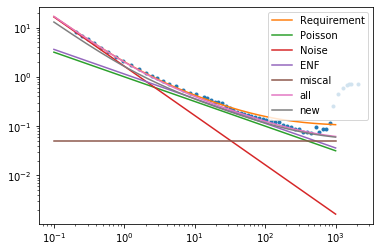

In [79]:
plt.plot(cr['illumination_pe'], cr['lab_charge_resolution'], '.')

q = np.geomspace(0.1, 1000, 1000)
poisson_limit = np.sqrt(q) / q
enf_limit = np.sqrt(1.2 * q) / q
# custom_limit = limit_curves(q, 0.125, 15, 0.87, 0.1, 0.095, 1)
# custom_limit2 = limit_curves(q, 0.125, 6, 0, 0.1, 0.039, 1)

nsb = 0.125
t_w = 8
n_e = 0.8
sigma_g = 0.05
sigma_enf = 1.3

custom_limit1 = limit_curves_new(q, nsb, t_w, n_e, 0, 0)
custom_limit2 = limit_curves_new(q, 0, 0, 0, 0, sigma_enf)
custom_limit3 = limit_curves_new(q, 0, 0, 0, sigma_g, 0)
custom_limit4 = limit_curves_new(q, nsb, t_w, n_e, sigma_g, sigma_enf)
enf_limit = np.sqrt(1.2 * q) / q
plt.plot(q, requirement(q), label="Requirement")
plt.plot(q, poisson_limit, label="Poisson")
# plt.plot(q, enf_limit)
plt.plot(q, custom_limit1, label="Noise")
plt.plot(q, custom_limit2, label="ENF")
plt.plot(q, custom_limit3, label="miscal")
plt.plot(q, custom_limit4, label="all")

nsb = 0.125
t_w = 8
n_e = 0.5
sigma_g = 0.05
sigma_enf = 1.08
custom_limit5 = limit_curves_new(q, nsb, t_w, n_e, sigma_g, sigma_enf)
plt.plot(q, custom_limit5, label="new")

plt.legend()



plt.xscale('log')
plt.yscale('log')

In [30]:
custom_limit3

array([2.12500000e+01, 2.10549847e+01, 2.08617591e+01, 2.06703068e+01,
       2.04806114e+01, 2.02926570e+01, 2.01064274e+01, 1.99219069e+01,
       1.97390798e+01, 1.95579305e+01, 1.93784436e+01, 1.92006040e+01,
       1.90243964e+01, 1.88498059e+01, 1.86768176e+01, 1.85054169e+01,
       1.83355892e+01, 1.81673200e+01, 1.80005951e+01, 1.78354002e+01,
       1.76717213e+01, 1.75095446e+01, 1.73488562e+01, 1.71896424e+01,
       1.70318898e+01, 1.68755849e+01, 1.67207145e+01, 1.65672653e+01,
       1.64152243e+01, 1.62645787e+01, 1.61153156e+01, 1.59674223e+01,
       1.58208862e+01, 1.56756949e+01, 1.55318361e+01, 1.53892975e+01,
       1.52480670e+01, 1.51081325e+01, 1.49694823e+01, 1.48321046e+01,
       1.46959875e+01, 1.45611196e+01, 1.44274895e+01, 1.42950857e+01,
       1.41638969e+01, 1.40339122e+01, 1.39051203e+01, 1.37775104e+01,
       1.36510715e+01, 1.35257930e+01, 1.34016643e+01, 1.32786747e+01,
       1.31568137e+01, 1.30360712e+01, 1.29164366e+01, 1.27979001e+01,
      

In [15]:
np.sqrt(1.2)

1.0954451150103321

In [16]:
np.sqrt(1.08)

1.0392304845413265